# Chap7 支持向量机

最大边际分类器

## 1.概述

### 1.1 工作原理

支持向量机的分类方法，是在这组分布中找出一个**超平面**作为决策边界，使模型在数据上的分类误差尽量接近于小，尤其是在未知数据集上的分类误差（泛化误差）尽量小。

**关键概念：超平面**
在几何中，超平面是一个空间的子空间，它是维度比所在空间小一维的空间。 如果数据空间本身是三维的，则其超平面是二维平面，而如果数据空间本身是二维的，则其超平面是一维的直线。
在二分类问题中，如果一个超平面能够将数据划分为两个集合，其中每个集合中包含单独的一个类别，我们就说这个超平面是数据的“决策边界。

**拥有更大边际的决策边界在分类中的泛化误差更小**。如果边际很小，则任何轻微扰动都会对决策边界的分类产生很大的影响。边际很小的情况，是一种模型在训练集上表现很好，却在测试集上表现糟糕的情况，所以会“过拟合”。所以我们在找寻决策边界的时候，希望边际越大越好

## 2 sklearn.svm.SVC

利用支持向量机进行分类

class sklearn.svm.SVC (C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True,probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1,decision_function_shape=’ovr’, random_state=None)

### 2.1 分类原理

#### 2.1.1 损失函数详解

**决策边界** $w^T*x+b=0$
- 目的：求解边际最大化决策边界
- 求解参数$w$和$b$
  - 其中$w$的方向垂直于决策边界
  - 给出新的数据$x$，其分类的表达式如下
  
$$y=\begin{cases}
1,\quad if  w*x+b>0 \\\\
-1,\quad if w*x+b<0
\end{cases}$$

**损失函数**
$$\min{\frac{||w||^2}{2}}$$
$$s.t. y_i(w^T*x+b) >= 1$$

#### 2.1.2 线性SVM决策过程的可视化

- .predict(X) 根据决策边界，对X中的样本进行分类，返回的结构为n_samples
- .score(X,y) 返回给定测试数据和标签的平均准确度
- .support_vectors_ 返回支持向量
- clf.n_support_ 返回每个类中支持向量的个数

##### 1.线性SVM决策过程的可视化

In [1]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

##### 2.实例化数据集，可视化数据集

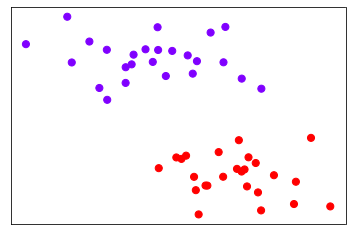

In [2]:
X,y = make_blobs(n_samples=50, centers=2, random_state=0,cluster_std=0.6)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")  # cmap 点的颜色
plt.xticks([])  # 不显示横纵坐标
plt.yticks([])
plt.show()

##### 3.画决策边界：理解函数contour

- matplotlib.axes.Axes.contour([X, Y,] Z, [levels], **kwargs)

Contour是我们专门用来绘制等高线的函数。等高线，本质上是在二维图像上表现三维图像的一种形式，其中两维X和Y是两条坐标轴上的取值，而Z表示高度。Contour就是将由X和Y构成平面上的所有点中，高度一致的点连接成线段的函数，在同一条等高线上的点一定具有相同的Z值。我们可以利用这个性质来绘制我们的决策边界。

获取样本构成的平面，作为一个对象

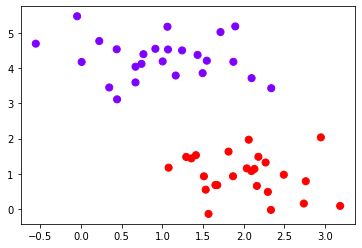

In [3]:
#首先要有散点图
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")

ax = plt.gca() #获取当前的子图，如果不存在，则创建新的子图

##### 4.画决策边界：制作网格，理解函数meshgrid

(-0.7425578984849813, 3.3721920271976598) (-0.41872382476349596, 5.754870487889891)


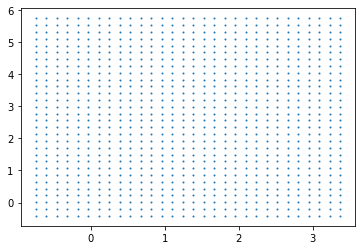

In [4]:
#获取平面上两条坐标轴的最大值和最小值
xlim = ax.get_xlim()
ylim = ax.get_ylim()
print(xlim,ylim)

# 在最小值和最大值之间形成30个规律的数据
axisx = np.linspace(xlim[0],xlim[1],30)
axisy = np.linspace(ylim[0],ylim[1],30)

axisx,axisy = np.meshgrid(axisx,axisy)
axisx.shape
#使用meshgrid函数将两个一维向量转换为特征矩阵
#核心是将两个特征向量广播，以便获取y.shape * x.shape这么多个坐标点的横坐标和纵坐标

xy = np.vstack([axisx.ravel(), axisy.ravel()]).T
#其中ravel()是降维函数，vstack能够将多个结构一致的一维数组按行堆叠起来
#xy就是已经形成的网格，它是遍布在整个画布上的密集的点


plt.scatter(xy[:,0],xy[:,1],s=1,cmap="rainbow")

#理解函数meshgrid和vstack的作用
a = np.array([1,2,3])
b = np.array([7,8])
#两两组合，会得到多少个坐标？
#答案是6个，分别是 (1,7),(2,7),(3,7),(1,8),(2,8),(3,8)
v1,v2 = np.meshgrid(a,b)
v1
v2
v = np.vstack([v1.ravel(), v2.ravel()]).T

##### 5.建模，计算决策边界并找出网格上每个点到决策边界的距离


In [5]:
#建模，通过fit计算出对应的决策边界
from mailbox import linesep


clf = SVC(kernel = "linear").fit(X,y)
Z = clf.decision_function(xy).reshape(axisx.shape)
#重要接口decision_function，返回每个输入的样本所对应的到决策边界的距离
#然后再将这个距离转换为axisx的结构，这是由于画图的函数contour要求Z的结构必须与X和Y保持一致

Z.shape

# 画决策边界和平行与决策边界的超平面
ax.contour(axisx,axisy,Z,colors = 'k',
            level = [-1,0,1],   # 绘制三个值的等高线
            alpha=0.1,linestyles=['--','-','--'])

# 设置横轴和纵轴的坐标 
ax.set_xlim(xlim)
ax.set_ylim(ylim)

C:\Users\HP\AppData\Local\Temp\ipykernel_9788\776486878.py:13: UserWarning: The following kwargs were not used by contour: 'level'
  ax.contour(axisx,axisy,Z,colors = 'k',


(-0.41872382476349596, 5.754870487889891)

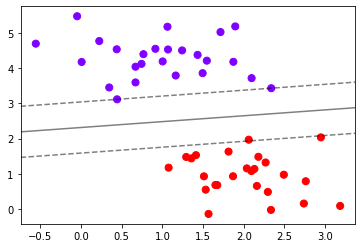

In [6]:
#————————————————————————————包装成函数————————————————————————————
#将上述过程包装成函数：
def plot_svc_decision_function(model,ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0],xlim[1],30)
    y = np.linspace(ylim[0],ylim[1],30)
    Y,X = np.meshgrid(y,x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    ax.contour(X, Y, P,colors="k",levels=[-1,0,1],alpha=0.5,linestyles=["--","-","--"])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#则整个绘图过程可以写作：
clf = SVC(kernel = "linear").fit(X,y)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")
plot_svc_decision_function(clf)

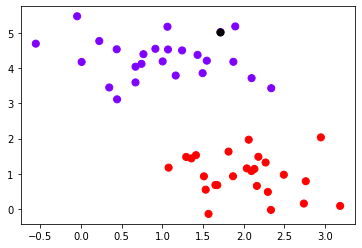

In [7]:
#记得Z的本质么？是输入的样本到决策边界的距离，而contour函数中的level其实是输入了这个距离
#让我们用一个点来试试看
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")
plt.scatter(X[10,0],X[10,1],c="black",s=50,cmap="rainbow")


In [8]:
clf.decision_function(X[10].reshape(1,2))


array([-3.33917354])

In [9]:
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")
ax = plt.gca()
ax.contour(axisx,axisy,
            ,colors="k"
            ,levels=[-3.33917354]
            ,alpha=0.5
            ,linestyles=["--"])

SyntaxError: invalid syntax (609192056.py, line 4)

##### 6.探索建好的模型

In [ ]:
clf.predict(X)
#根据决策边界，对X中的样本进行分类，返回的结构为n_samples


array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

In [ ]:
clf.score(X,y)
#返回给定测试数据和标签的平均准确度


1.0

In [ ]:
clf.support_vectors_
#返回支持向量


array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [ ]:
clf.n_support_
#返回每个类中支持向量的个数

array([2, 1])

##### 7.推广到非线性情况

如果我们能够在原本的X和y的基础上，添加一个维度r，变成三维，我们可视化这个数据，来看看添加维度让我们的数据如何变化

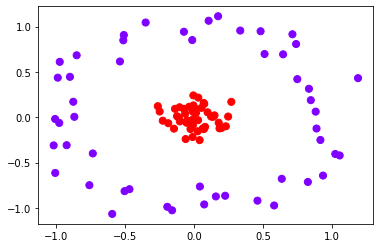

In [ ]:
# 环性数据
from sklearn.datasets import make_circles
X,y = make_circles(100, factor=0.1, noise=.1)

X.shape
y.shape

plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")
plt.show()


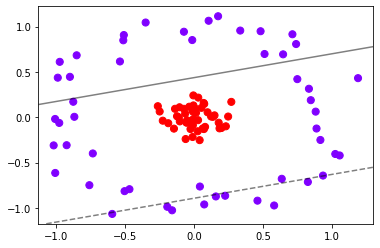

In [ ]:
clf = SVC(kernel = "linear").fit(X,y)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")
plot_svc_decision_function(clf)

##### 9.为非线性数据增加维度并绘制3D图像

In [ ]:
#定义一个由x计算出来的新维度r
r = np.exp(-(X**2).sum(1))


In [ ]:
rlim = np.linspace(min(r),max(r),100)
rlim

array([0.2028063 , 0.21085421, 0.21890213, 0.22695005, 0.23499797,
       0.24304589, 0.25109381, 0.25914173, 0.26718965, 0.27523757,
       0.28328549, 0.29133341, 0.29938133, 0.30742924, 0.31547716,
       0.32352508, 0.331573  , 0.33962092, 0.34766884, 0.35571676,
       0.36376468, 0.3718126 , 0.37986052, 0.38790844, 0.39595636,
       0.40400428, 0.41205219, 0.42010011, 0.42814803, 0.43619595,
       0.44424387, 0.45229179, 0.46033971, 0.46838763, 0.47643555,
       0.48448347, 0.49253139, 0.50057931, 0.50862722, 0.51667514,
       0.52472306, 0.53277098, 0.5408189 , 0.54886682, 0.55691474,
       0.56496266, 0.57301058, 0.5810585 , 0.58910642, 0.59715434,
       0.60520225, 0.61325017, 0.62129809, 0.62934601, 0.63739393,
       0.64544185, 0.65348977, 0.66153769, 0.66958561, 0.67763353,
       0.68568145, 0.69372937, 0.70177729, 0.7098252 , 0.71787312,
       0.72592104, 0.73396896, 0.74201688, 0.7500648 , 0.75811272,
       0.76616064, 0.77420856, 0.78225648, 0.7903044 , 0.79835

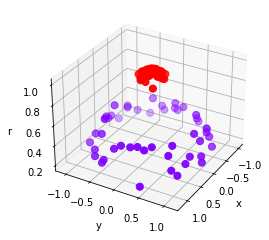

In [ ]:
from mpl_toolkits import mplot3d
#定义一个绘制三维图像的函数
#elev表示上下旋转的角度
#azim表示平行旋转的角度

def plot_3D(elev=30,azim=30,X=X,y=y):
    ax = plt.subplot(projection="3d")   # 建立3D的子图
    ax.scatter3D(X[:,0],X[:,1],r,c=y,s=50,cmap='rainbow')  # 绘制3D的点图
    ax.view_init(elev=elev,azim=azim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("r")
    plt.show()

plot_3D()

# 此时此刻我们的数据明显是线性可分的了：我们可以使用一个平面来将数据完全分开，并使平面的上方的所有数据点为一类，平面下方的所有数据点为另一类。

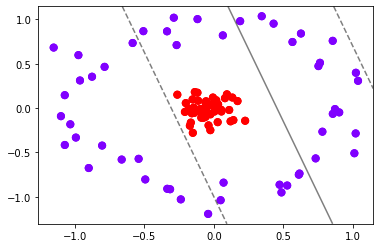

interactive(children=(Dropdown(description='elev', index=1, options=(0, 30, 60, 90), value=30), IntSlider(valu…

In [ ]:
#如果放到jupyter notebook中运行
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_circles
X,y = make_circles(100, factor=0.1, noise=.1)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")

def plot_svc_decision_function(model,ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0],xlim[1],30)
    y = np.linspace(ylim[0],ylim[1],30)
    Y,X = np.meshgrid(y,x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P,colors="k",levels=[-1,0,1],alpha=0.5,linestyles=["--","-","--"])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


clf = SVC(kernel = "linear").fit(X,y)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap="rainbow")
plot_svc_decision_function(clf)
r = np.exp(-(X**2).sum(1))
rlim = np.linspace(min(r),max(r),100)


from mpl_toolkits import mplot3d

def plot_3D(elev=30,azim=30,X=X,y=y):
    ax = plt.subplot(projection="3d")
    ax.scatter3D(X[:,0],X[:,1],r,c=y,s=50,cmap='rainbow')
    ax.view_init(elev=elev,azim=azim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("r")
    plt.show()


from ipywidgets import interact,fixed
# 进行3D互动
interact(plot_3D,elev=[0,30,60,90],azip=(-180,180),X=fixed(X),y=fixed(y))
plt.show()

**“核变换”**

即是将数据投影到高维空间中，以寻找能够将数据完美分割的超平面，即是说寻找能够让数据线性可分的高维空间。为了详细解释这个过程，我们需要引入SVM中的核心概念：核函数。

## 2.2 非线性SVM与核函数

使用一种变换对源数据进行升维

#### 2.2.1 重要参数kernel

**关键概念：核函数**
而解决这些问题的数学方式，叫做“核技巧”(Kernel Trick)，是一种能够使用数据原始空间中的向量计算来表示升维后的空间中的点积结果的数学方式。具体表现为$K(u,v)=\Phi{(u)}.\Phi{(v)}$ 。而这个原始空间中的点积函数 ，就被叫做“核函数”(Kernel Function)。

- linear 线性核 --> 线性
- poly 多项式核 --> 偏线性
- sigmoid 双曲正切核  --> 非线性
- rbf 高斯径向基  --> 偏非线性

#### 2.2.2 探索核函数在不同数据集上的表现

1. 导入所需要的库和模块


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.datasets import make_circles, make_moons, make_blobs,make_classification


2. 创建数据集，定义核函数的选择


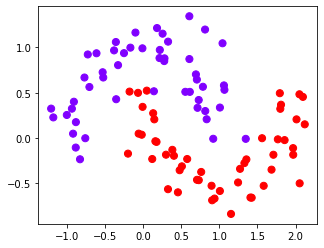

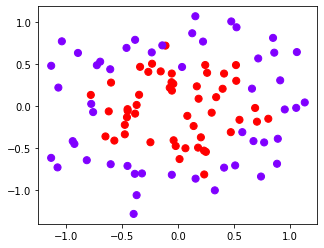

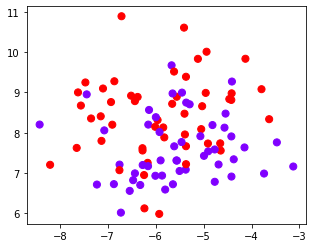

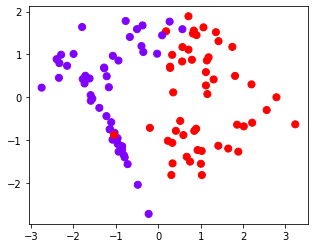

In [ ]:
n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samples, centers=2, random_state=5),
    make_classification(n_samples=n_samples,n_features =
    2,n_informative=2,n_redundant=0, random_state=5)
    ]
Kernel = ["linear","poly","rbf","sigmoid"]

#四个数据集分别是什么样子呢？
for X,Y in datasets:
    plt.figure(figsize=(5,4))
    plt.scatter(X[:,0],X[:,1],c=Y,s=50,cmap="rainbow")

3. 构建子图


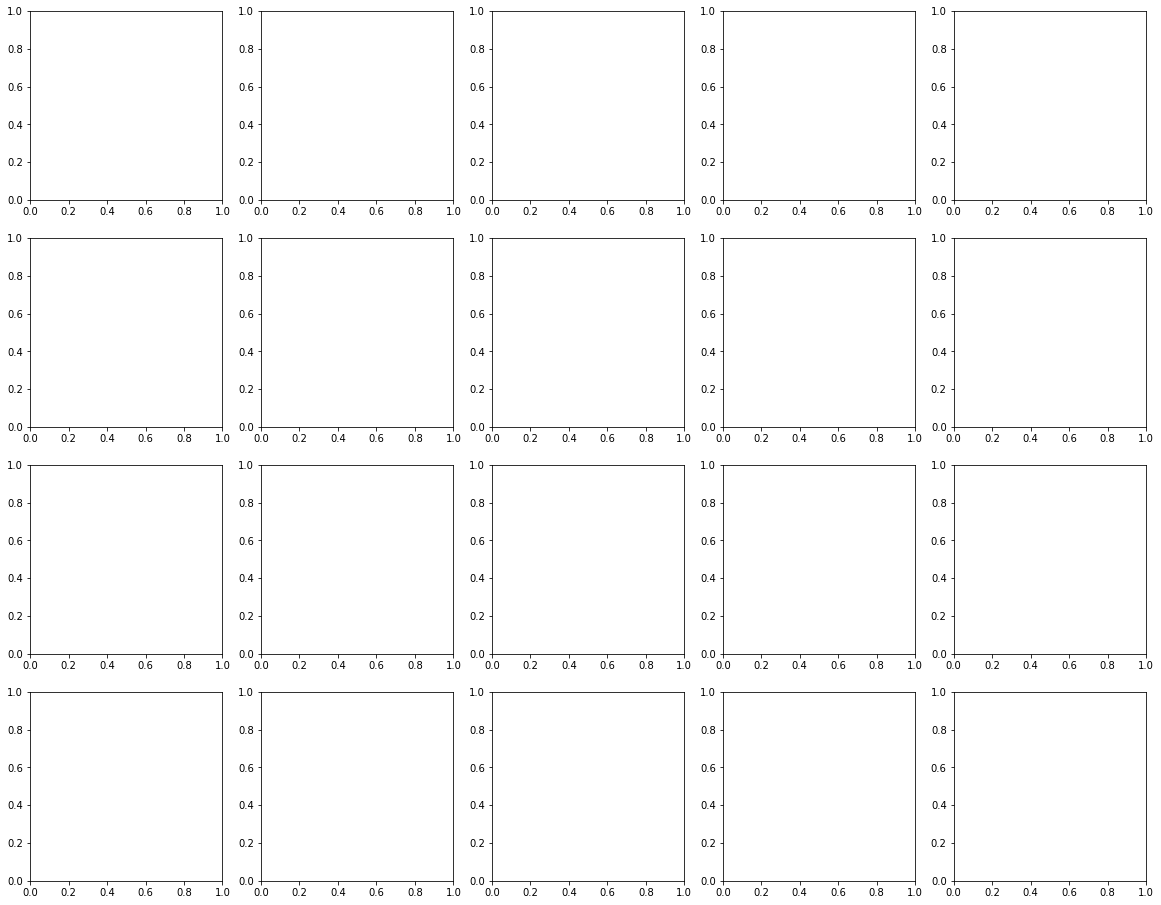

In [ ]:
nrows=len(datasets)
ncols=len(Kernel) + 1

fig, axes = plt.subplots(nrows, ncols,figsize=(20,16))

4. 开始进行子图循环

- 利用[* 对象] 打开惰性对象
  - 惰性对象 map zip enumerate 形成的对象

In [ ]:
#第一层循环：在不同的数据集中循环
for ds_cnt, (X,Y) in enumerate(datasets):

    #在图像中的第一列，放置原数据的分布
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())

    #第二层循环：在不同的核函数中循环
    #从图像的第二列开始，一个个填充分类结果
    for est_idx, kernel in enumerate(Kernel):
         #定义子图位置
        ax = axes[ds_cnt, est_idx + 1]

         #建模
        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, Y)
        score = clf.score(X, Y)

        #绘制图像本身分布的散点图
        ax.scatter(X[:, 0], X[:, 1], c=Y
                    ,zorder=10
                    ,cmap=plt.cm.Paired,edgecolors='k')
                    
        #绘制支持向量
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50,
        facecolors='none', zorder=10, edgecolors='k')
        #绘制决策边界
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        #np.mgrid，合并了我们之前使用的np.linspace和np.meshgrid的用法
        #一次性使用最大值和最小值来生成网格
        #表示为[起始值：结束值：步长]
        #如果步长是复数，则其整数部分就是起始值和结束值之间创建的点的数量，并且结束值被包含在内
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        #np.c_，类似于np.vstack的功能
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        #填充等高线不同区域的颜色
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        #绘制等高线
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-1, 0, 1])
        #设定坐标轴为不显示
        ax.set_xticks(())
        ax.set_yticks(())
        #将标题放在第一行的顶上
        if ds_cnt == 0:
            ax.set_title(kernel)
        #为每张图添加分类的分数
        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0')
                , size=15
                , bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')
                #为分数添加一个白色的格子作为底色
                , transform=ax.transAxes #确定文字所对应的坐标轴，就是ax子图的坐标轴本身
                , horizontalalignment='right' #位于坐标轴的什么方向
                )
                
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_20512\2061904253.py:43: UserWarning: No contour levels were found within the data range.
  ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],


<Figure size 432x288 with 0 Axes>

#### 2.2.4 探索核函数的优势和缺陷

**在运行SVM，建议先标准化统一量纲**

- datetime.fromdatastamp(time()).
- strftime('时间格式') 将时间戳转换成时间的格式

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from time import time
import datetime

In [11]:
data = load_breast_cancer()
X = data.data
y = data.target
X.shape


(569, 30)

In [12]:
np.unique(y)  # 去重


array([0, 1])

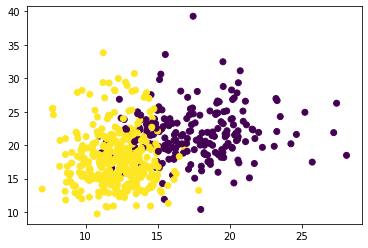

In [13]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [14]:
from sklearn.decomposition import PCA



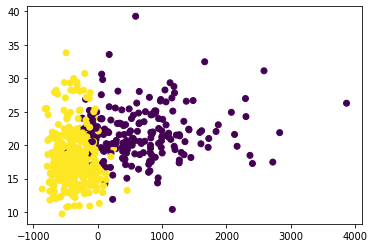

In [15]:
#————————————————————————————利用PCA降维至两维————————————————————————————
X_dr = PCA(2).fit_transform(X)
X_dr.shape

plt.scatter(X_dr[:,0],X[:,1],c=y)
plt.show()

In [16]:
Xtrain,Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3,random_state=420)


In [17]:
Kernel = ['linear',
        #'poly',
        'rbf','sigmoid']
for kernel in Kernel:
    time0= time()
    clf = SVC(kernel=kernel,
            gamma='auto',
            cache_size=5000   # 使用多少M 的内存进行运算
            ).fit(Xtrain,Ytrain)

    print('The accuracy kernel %s is %f'%(kernel,clf.score(Xtest,Ytest)))   # 利用测试集给出当前核函数的打分
    print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f'))

#这证明，多项式核函数此时此刻要消耗大量的时间，运算非常的缓慢。
# 让我们在循环中去掉多项式核函数，再试试看能否跑出结果

The accuracy kernel linear is 0.929825
00:01:567799
The accuracy kernel rbf is 0.596491
00:00:151593
The accuracy kernel sigmoid is 0.596491
00:00:016965


此处高斯核函数rbf的效果较差

In [18]:
import pandas as pd

data = pd.DataFrame(X)
data.describe([0.01,0.1,0.5,0.75,0.9,0.99]).T

# 这个数据量纲严重不统一
# 偏态问题

,count,mean,std,min,1%,10%,50%,75%,90%,99%,max
0,569.0,14.127292,3.524049,6.981000,8.458360,10.260000,13.370000,15.780000,19.530000,24.371600,28.11000
1,569.0,19.289649,4.301036,9.710000,10.930400,14.078000,18.840000,21.800000,24.992000,30.652000,39.28000
2,569.0,91.969033,24.298981,43.790000,53.827600,65.830000,86.240000,104.100000,129.100000,165.724000,188.50000
3,569.0,654.889104,351.914129,143.500000,215.664000,321.600000,551.100000,782.700000,1177.400000,1786.600000,2501.00000
4,569.0,0.096360,0.014064,0.052630,0.068654,0.079654,0.095870,0.105300,0.114820,0.132888,0.16340
5,569.0,0.104341,0.052813,0.019380,0.033351,0.049700,0.092630,0.130400,0.175460,0.277192,0.34540
6,569.0,0.088799,0.079720,0.000000,0.000000,0.013686,0.061540,0.130700,0.203040,0.351688,0.42680
7,569.0,0.048919,0.038803,0.000000,0.000000,0.011158,0.033500,0.074000,0.100420,0.164208,0.20120
8,569.0,0.181162,0.027414,0.106000,0.129508,0.149580,0.179200,0.195700,0.214940,0.259564,0.30400
9,569.0,0.062798,0.007060,0.049960,0.051504,0.055338,0.061540,0.066120,0.072266,0.085438,0.09744


In [21]:
# 数据标准化

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)


# 再次训练
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3,random_state=420)
Kernel = ["linear","poly","rbf","sigmoid"]

for kernel in Kernel:
    time0 = time()
    clf= SVC(kernel = kernel
    , gamma="auto"
    , degree = 1
    , cache_size=5000
    ).fit(Xtrain,Ytrain)

    print("The accuracy under kernel %s is %f" % (kernel,clf.score(Xtest,Ytest)))
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))


#

The accuracy under kernel linear is 0.976608
00:00:016961
The accuracy under kernel poly is 0.964912
00:00:005975
The accuracy under kernel rbf is 0.970760
00:00:014960
The accuracy under kernel sigmoid is 0.953216
00:00:005982


数据标准化以后4和核函数的效果都显著提高，且模型的运行时间大幅度缩小


#### 2.2.5 选取与核函数相关的参数：degree & gamma & coef0

4种核函数对相关参数的支持情况

- linear N N N
- poly Y Y Y
- sigmoid  Y N Y
- rbg Y N N

kernel"是唯一能够影响它的参数，但是对于其他三种非线性核函数，他们还受到参数gamma，degree以及coef0的影响。参数gamma就是表达式中的$\gamma$ ，degree就是多项式核函数的次数 ，参数coef0就是常数项 。其中，高斯径向基核函数受到gamma的影响，而多项式核函数受到全部三个参数的影响。 


- 设置交叉验证的模式
    - cv = StratifiedShuffleSplit(n_splits=5,test_size=0.3,random_state=420)
    - grid = GridSearchCV(SVC(kernel='poly',degree=1,cache_size=5000),param_grid=param_grid,cv=cv)
    - 交叉验证的第一个参数是分类器SVC  第二个参数 网格搜索的参数范围 第三个参数交叉验证的形式

0.9766081871345029 0.01151395399326447


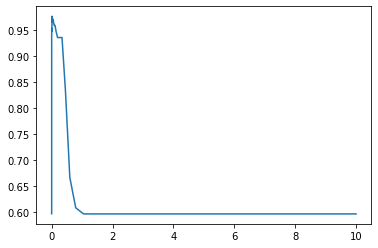

In [23]:
#————————————————————————————根据gamma的范围绘制学习曲线————————————————————————————
score = []
gamma_range = np.logspace(-5,1,50)
 
for i in gamma_range:
    clf = SVC(kernel='rbf',gamma=i,cache_size=5000).fit(Xtrain,Ytrain)
    score.append(clf.score(Xtest,Ytest))
print(max(score), gamma_range[score.index(max(score))])
plt.plot(gamma_range,score)
plt.show()

In [24]:
#————————————————————————————利用网格搜索对高斯核函数调参————————————————————————————
from sklearn.model_selection import StratifiedShuffleSplit  # 实现其中的网格搜索
from sklearn.model_selection import GridSearchCV   # 带交叉验证的网格搜索

time0 = time()

gamma_range = np.logspace(-10,1,20)
coef0_range= np.linspace(0,5,10)

param_grid = dict(gamma = gamma_range,coef0 = coef0_range)

# 设置交叉验证的模式
cv = StratifiedShuffleSplit(n_splits=5,test_size=0.3,random_state=420)
grid = GridSearchCV(SVC(kernel='poly',degree=1,cache_size=5000),param_grid=param_grid,cv=cv)
# 交叉验证的第一个参数是分类器SVC  第二个参数 网格搜索的参数范围 第三个参数交叉验证的形式

grid.fit(X,y)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_,grid.best_score_))
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

The best parameters are {'coef0': 0.0, 'gamma': 0.18329807108324375} with a score of 0.96959
00:18:677593


可以发现，网格搜索为我们返回了参数coef0=0，gamma=0.18329807108324375，但整体的分数是0.96959，虽然比调参前略有提高，但依然没有超过线性核函数核rbf的结果。可见，如果最初选择核函数的时候，你就发现多项式的结果不如rbf和线性核函数，那就不要挣扎了，试试看调整rbf或者直接使用线性

### 2.3 硬间隔与软间隔：重要参数C

#### 2.3.1 SVM在软间隔数据上的推广

适用于数据线性不可分的情况

**关键概念：硬间隔与软间隔**

- 当两组数据是完全线性可分，我们可以找出一个决策边界使得训练集上的分类误差为0，这两种数据就被称为是存在”硬间隔“的。

- 当两组数据几乎是完全线性可分的，但决策边界在训练集上存在较小的训练误差，这两种数据就被称为是存在”软间隔“

#### 2.3.2 重要参数C

- 设置惩罚项的力度

浮点数，默认1，必须大于等于0，可不填，松弛系数的惩罚项系数。如果C值设定比较大，那SVC可能会选择边际较小的，能够更好地分类所有训练点的决策边界，不过模型的训练时间也会更长。如果C的设定值较小，那SVC会尽量最大化边界，决策功能会更简单，但代价是训练的准确度。

0.9766081871345029 1.2340816326530613


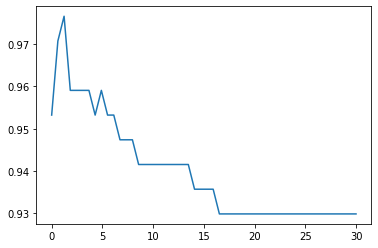

In [26]:
#调线性核函数
score = []
C_range = np.linspace(0.01,30,50)
for i in C_range:
    clf = SVC(kernel="linear",C=i,cache_size=5000).fit(Xtrain,Ytrain)
    score.append(clf.score(Xtest,Ytest))

print(max(score), C_range[score.index(max(score))])
plt.plot(C_range,score)
plt.show()

0.9824561403508771 6.130408163265306


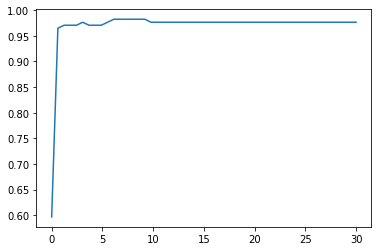

In [27]:

#换rbf
score = []
C_range = np.linspace(0.01,30,50)
for i in C_range:
    clf = SVC(kernel="rbf",C=i,gamma =
    0.012742749857031322,cache_size=5000).fit(Xtrain,Ytrain)
    score.append(clf.score(Xtest,Ytest))
print(max(score), C_range[score.index(max(score))])
plt.plot(C_range,score)
plt.show()
#进一步细化


0.9824561403508771 5.938775510204081


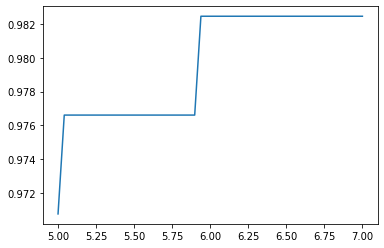

In [28]:
score = []
C_range = np.linspace(5,7,50)
for i in C_range:
    clf = SVC(kernel="rbf",C=i,gamma =
    0.012742749857031322,cache_size=5000).fit(Xtrain,Ytrain)
    score.append(clf.score(Xtest,Ytest))
print(max(score), C_range[score.index(max(score))])
plt.plot(C_range,score)
plt.show()